## Modelo 1

código de:
- <https://www.bayesianmodelsforastrophysicaldata.com/code-4-7>
- <https://github.com/astrobayes/BMAD/blob/master/chapter_4/code_4.7.py>

O codigo abaixo usa uma regressão pra cada coordenada do centro de massa do dataframe livro.csv.

In [89]:
livro = pd.read_csv('data/livro.csv')
livro

,intern_clock,1,2,3,4,x,y
0,31032,0.0,0.0,0.0,0.0,25.228563,-20.309231
1,31130,0.0,0.0,0.0,0.0,20.030073,-18.322621
2,31227,0.0,0.0,0.0,0.0,21.478640,-22.584932
3,31326,0.0,0.0,0.0,0.0,22.267633,-24.549507
4,31424,0.0,0.0,0.0,0.0,16.959957,-19.912392
...,...,...,...,...,...,...,...
699,99546,0.0,0.0,0.0,0.0,12.197288,31.348506
700,99643,0.0,0.0,0.0,0.0,12.502285,32.553389
701,99741,0.0,0.0,0.0,0.0,11.871969,33.459720
702,99840,0.0,0.0,0.0,0.0,11.883116,32.952679


In [114]:
# From: Bayesian Models for Astrophysical Data, Cambridge Univ. Press
# (c) 2017,  Joseph M. Hilbe, Rafael S. de Souza and Emille E. O. Ishida 
# 
# you are kindly asked to include the complete citation if you used this 
# material in a publication

# Code 4.7 - Multivariate normal linear model in Python using Stan
# 1 response (y) and 2 explanatory variables (x1, x2)

# ^^ a implementação foi inspirada no autor acima


import numpy as np
import statsmodels.api as sm
import stan
from scipy.stats import uniform, norm
import json
# Data
np.random.seed(1056)                 # set seed to replicate example
nobs= livro.shape[0]                         # number of obs in model 
x1 = livro['1'].to_numpy()          # random uniform variable
x2 = livro['2'].to_numpy()          # second explanatory
x3 = livro['3'].to_numpy()
x4 = livro['4'].to_numpy()

X = np.column_stack((x1,x2, x3, x4))        # create response matrix
# X = np.column_stack((x1, x2))
X = sm.add_constant(X)              # add intercept

y = livro['x'].to_numpy() # agora faz regressão na abcissa do centro de massa calculado do corpo de prova

# Fit
data = {}                                # build data dictionary
data['nobs'] = nobs                      # sample size
data['x'] = X                            # explanatory variable         
data['y'] = y                            # response variable
data['k'] = data['x'].shape[1]       # number of explanatory variables

# data = json.dumps(list(data))

# data = data.to_json()



# O QUE TA ACONTECENDO AAAAAAAAAAAAAAAAAAAAAAAAAAAAA




# STAN code
stan_code = """
data {
    int<lower=1> k;  
    int<lower=0> nobs;                                 
    matrix[nobs, k] x;                     
    vector[nobs] y;                     
}
parameters {
    matrix[k,1] beta;                                             
    real<lower=0> sigma;               
}
transformed parameters{
    matrix[nobs,1] mu;
    vector[nobs] mu2;

    mu = x * beta;
    mu2 = to_vector(mu);                 // normal distribution 
                                         // does not take matrices as input
}
model {
    for (i in 1:k){                      // Diffuse normal priors for predictors
        beta[i] ~ normal(0.0, 100);
    }
    sigma ~ uniform(0, 10);             // A variância dos sensores nao é baixa mas eles são relativamente confiáveis

    y ~ normal(mu2, sigma);              // Likelihood function
}
"""

# Compile model
model = stan.build(stan_code, data)

# perform fit
fit1 = model.sample(num_chains=4, num_samples=1000)


# Output
nlines = 9                                   # number of lines in screen output

output = str(fit).split('\n')
for item in output[:nlines]:
    print(item)   

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_v5mill6j/model_hmhpf5jv.stan', line 24, column 23: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_v5mill6j/model_hmhpf5jv.stan', line 24, column 4: Parameter
    sigma is given a uniform distribution. The uniform distribution is not
    recommended, for two reasons: (a) Except when there are logical or
    physical constraints, it is very unusual for you to be sure that a
    parameter will fall inside a specified range, and (b) The infinite
    gradient induced by a uniform density can cause difficulties for Stan's
    sampling algorithm. As a consequence, we recommend soft constraints
    rather than hard constraints; for example, instead of giving an
    elasticity parameter a uniform(0,1) distribution, try normal(0.5,0.5).
Warning in '/tmp/httpstan_v5mill6j/model_hmhpf5jv.stan', line

<stan.Fit>
Parameters:
    alpha: ()
    beta: ()
    sigma: ()
Draws: 4000


In [120]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

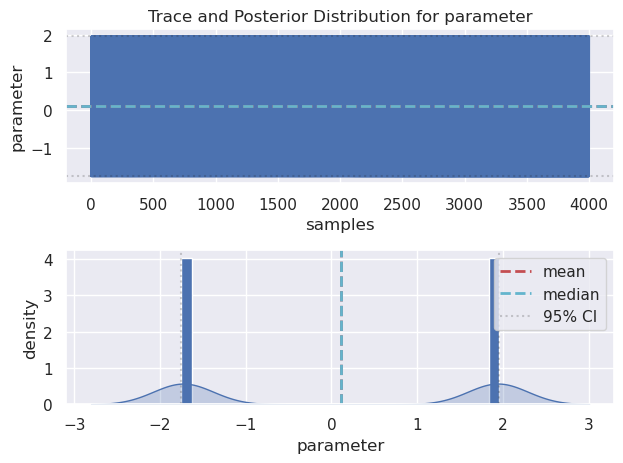

In [125]:
a = fit1["beta"][0].reshape(4000,)

plot_trace(a)

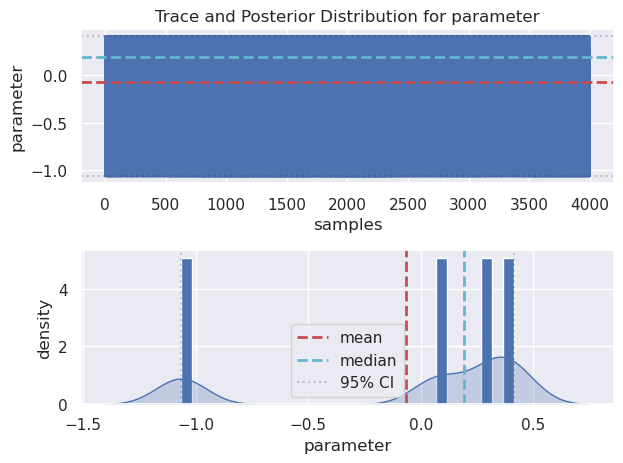

In [126]:
b = fit1["beta"][2].reshape(4000,)

plot_trace(b)

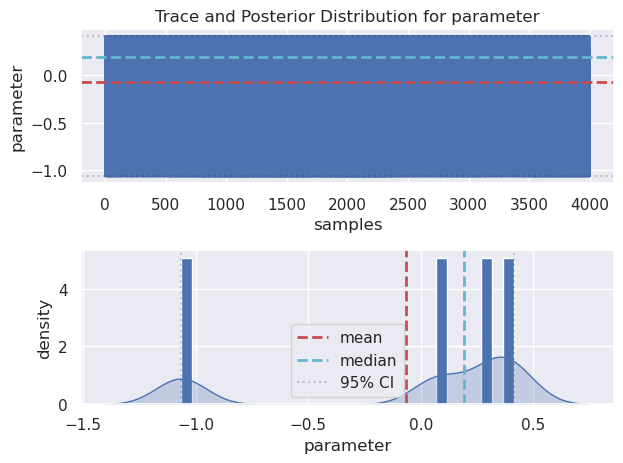

In [127]:
c = fit1["beta"][2].reshape(4000,)

plot_trace(c)

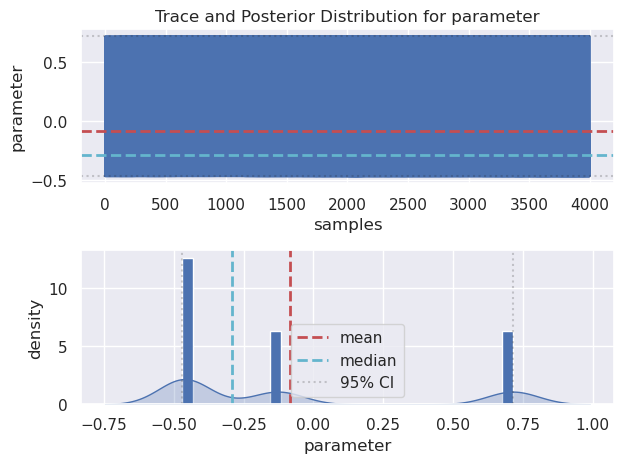

In [128]:
d = fit1["beta"][3].reshape(4000,)

plot_trace(d)

O resultado é estranhíssimo.
Agora com a ordenada:

In [131]:
# From: Bayesian Models for Astrophysical Data, Cambridge Univ. Press
# (c) 2017,  Joseph M. Hilbe, Rafael S. de Souza and Emille E. O. Ishida 
# 
# you are kindly asked to include the complete citation if you used this 
# material in a publication

# Code 4.7 - Multivariate normal linear model in Python using Stan
# 1 response (y) and 2 explanatory variables (x1, x2)

# ^^ a implementação foi inspirada no autor acima


import numpy as np
import statsmodels.api as sm
import stan
from scipy.stats import uniform, norm
import json
# Data
np.random.seed(1056)                 # set seed to replicate example
nobs= livro.shape[0]                         # number of obs in model 
x1 = livro['1'].to_numpy()          # random uniform variable
x2 = livro['2'].to_numpy()          # second explanatory
x3 = livro['3'].to_numpy()
x4 = livro['4'].to_numpy()

X = np.column_stack((x1,x2, x3, x4))        # create response matrix
# X = np.column_stack((x1, x2))
X = sm.add_constant(X)              # add intercept

y = livro['y'].to_numpy() # agora faz regressão na abcissa do centro de massa calculado do corpo de prova

# Fit
data = {}                                # build data dictionary
data['nobs'] = nobs                      # sample size
data['x'] = X                            # explanatory variable         
data['y'] = y                            # response variable
data['k'] = data['x'].shape[1]       # number of explanatory variables

# data = json.dumps(list(data))

# data = data.to_json()



# O QUE TA ACONTECENDO AAAAAAAAAAAAAAAAAAAAAAAAAAAAA




# STAN code
stan_code = """
data {
    int<lower=1> k;  
    int<lower=0> nobs;                                 
    matrix[nobs, k] x;                     
    vector[nobs] y;                     
}
parameters {
    matrix[k,1] beta;                                             
    real<lower=0> sigma;               
}
transformed parameters{
    matrix[nobs,1] mu;
    vector[nobs] mu2;

    mu = x * beta;
    mu2 = to_vector(mu);                 // normal distribution 
                                         // does not take matrices as input
}
model {
    for (i in 1:k){                      // Diffuse normal priors for predictors
        beta[i] ~ normal(0.0, 100);
    }
    sigma ~ uniform(0, 10);             // Uniform prior for standard deviation

    y ~ normal(mu2, sigma);              // Likelihood function
}
"""

# Compile model
model = stan.build(stan_code, data)

# perform fit
fit1 = model.sample(num_chains=4, num_samples=1000)


# Output
nlines = 9                                   # number of lines in screen output

output = str(fit).split('\n')
for item in output[:nlines]:
    print(item)   

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_v5mill6j/model_hmhpf5jv.stan', line 24, column 23: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_v5mill6j/model_hmhpf5jv.stan', line 24, column 4: Parameter
    sigma is given a uniform distribution. The uniform distribution is not
    recommended, for two reasons: (a) Except when there are logical or
    physical constraints, it is very unusual for you to be sure that a
    parameter will fall inside a specified range, and (b) The infinite
    gradient induced by a uniform density can cause difficulties for Stan's
    sampling algorithm. As a consequence, we recommend soft constraints
    rather than hard constraints; for example, instead of giving an
    elasticity parameter a uniform(0,1) distribution, try normal(0.5,0.5).
Warning in '/tmp/httpstan_v5mill6j/model_hmhpf5jv.stan', line

<stan.Fit>
Parameters:
    alpha: ()
    beta: ()
    sigma: ()
Draws: 4000


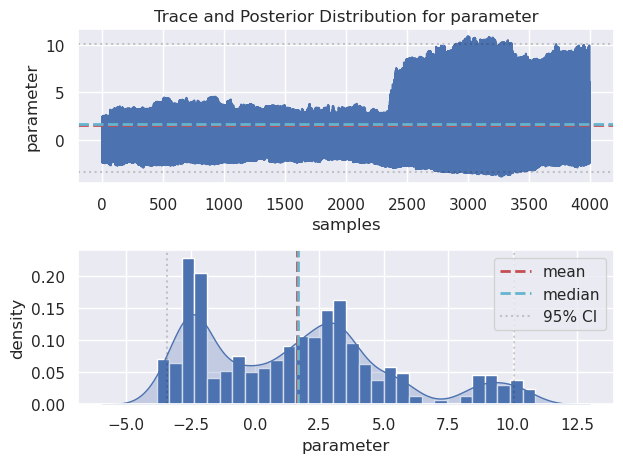

In [132]:
a = fit1["beta"][0].reshape(4000,)

plot_trace(a)

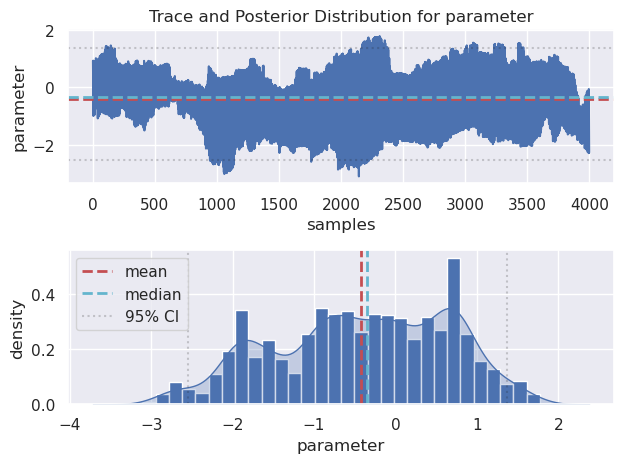

In [133]:
b = fit1["beta"][2].reshape(4000,)

plot_trace(b)

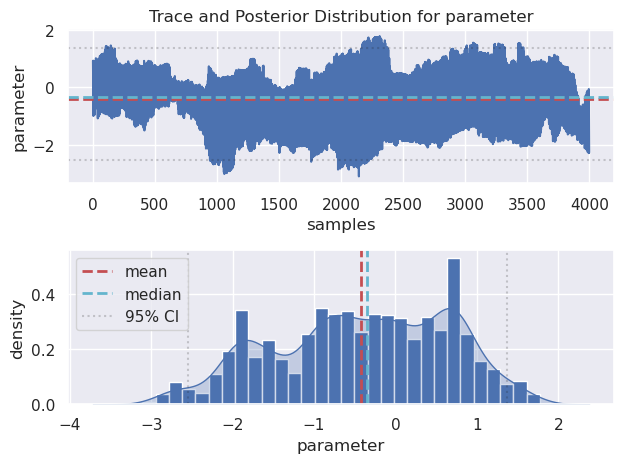

In [134]:
c = fit1["beta"][2].reshape(4000,)

plot_trace(c)

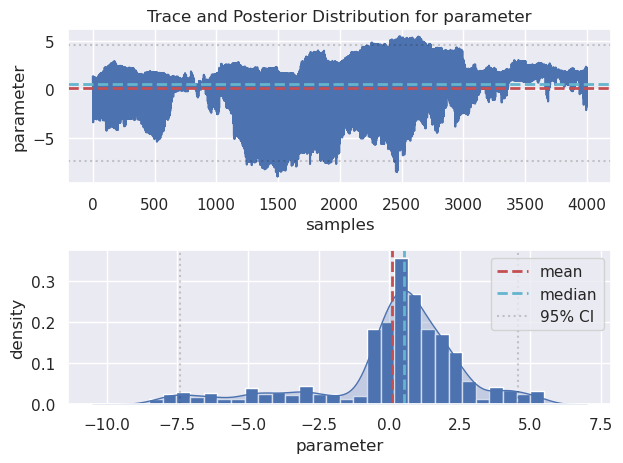

In [135]:
d = fit1["beta"][3].reshape(4000,)

plot_trace(d)